In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np

DATA_DIR = "../capstone/data/input"
IMAGE_DIR = "../images"
FILENAME = "cs-input.h5"

plt.style.use('seaborn')

In [2]:
os.listdir(DATA_DIR)

['cs-input.h5', 'preprocessed-dataset.h5', 'preprocessed-dataset.pkl']

In [3]:
df = pd.read_hdf(DATA_DIR + "/" + FILENAME)

In [4]:
df.head()

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day
0,United Kingdom,13085.0,489434,6.95,85048,12,2017,11,28
1,United Kingdom,NaN,489597,8.65,22130,1,2017,11,28
2,United Kingdom,NaN,489597,1.70,22132,6,2017,11,28
3,United Kingdom,NaN,489597,1.70,22133,4,2017,11,28
4,United Kingdom,NaN,489597,0.87,22134,1,2017,11,28


In [5]:
df["timestamp"] = pd.to_datetime(df[["year", "month", "day"]])
df.set_index("timestamp", inplace=True)

In [6]:
df.head()

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day
timestamp,,,,,,,,,
2017-11-28,United Kingdom,13085.0,489434,6.95,85048,12,2017,11,28
2017-11-28,United Kingdom,NaN,489597,8.65,22130,1,2017,11,28
2017-11-28,United Kingdom,NaN,489597,1.70,22132,6,2017,11,28
2017-11-28,United Kingdom,NaN,489597,1.70,22133,4,2017,11,28
2017-11-28,United Kingdom,NaN,489597,0.87,22134,1,2017,11,28


Text(0, 0.5, "cumulative evolution of 'price'")

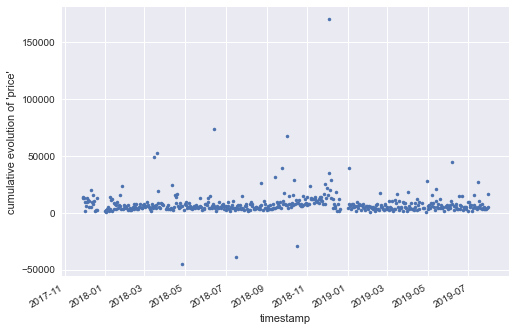

In [7]:
df.groupby("timestamp").sum()["price"].plot(marker=".", linestyle='None')
plt.ylabel("cumulative evolution of 'price'")

In [8]:
df["price"].isnull().sum()

0

In [9]:
df.loc[df["price"]<0, :]

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day
timestamp,,,,,,,,,
2018-04-26,United Kingdom,NaN,A506401,-53594.36,B,1,2018,4,26
2018-07-16,United Kingdom,NaN,A516228,-44031.79,B,1,2018,7,16
2018-10-17,United Kingdom,NaN,A528059,-38925.87,B,1,2018,10,17


In [10]:
df["zscore_price"] = zscore(df["price"])

In [11]:
price_no_outliers = df.loc[np.abs(df["zscore_price"]) <= 2, "price"]

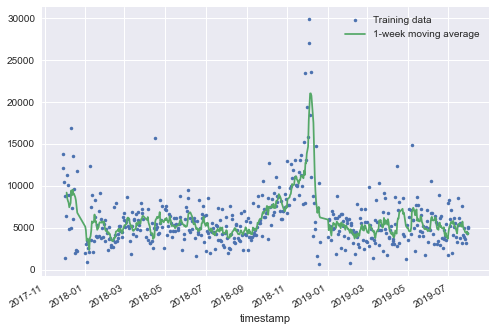

In [12]:
ts_agg = price_no_outliers.groupby("timestamp").sum()
ts_agg.plot(marker=".", linestyle="None", label="Training data")
ts_agg.rolling(window=7).mean().plot(label="1-week moving average")
plt.legend()
plt.savefig(IMAGE_DIR + "/moving-average-1-week.png")

In [13]:
df.isnull().sum()

country              0
customer_id     189762
invoice              0
price                0
stream_id            0
times_viewed         0
year                 0
month                0
day                  0
zscore_price         0
dtype: int64

In [14]:
df.drop(labels=['customer_id'], axis=1, inplace=True)
print("Dropped column customer id")

Dropped column customer id


In [15]:
df.head()

,country,invoice,price,stream_id,times_viewed,year,month,day,zscore_price
timestamp,,,,,,,,,
2017-11-28,United Kingdom,489434,6.95,85048,12,2017,11,28,0.015900
2017-11-28,United Kingdom,489597,8.65,22130,1,2017,11,28,0.028487
2017-11-28,United Kingdom,489597,1.70,22132,6,2017,11,28,-0.022972
2017-11-28,United Kingdom,489597,1.70,22133,4,2017,11,28,-0.022972
2017-11-28,United Kingdom,489597,0.87,22134,1,2017,11,28,-0.029118


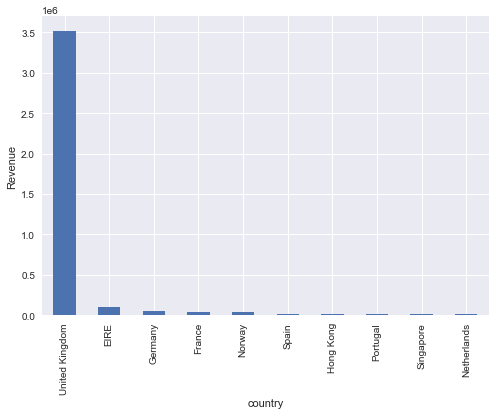

In [16]:
df.groupby(by=["country"]).sum()['price'].sort_values(ascending=False)[0:10].plot(kind='bar')
plt.ylabel("Revenue")
plt.savefig(IMAGE_DIR + "/total-revenue-by-country.png")

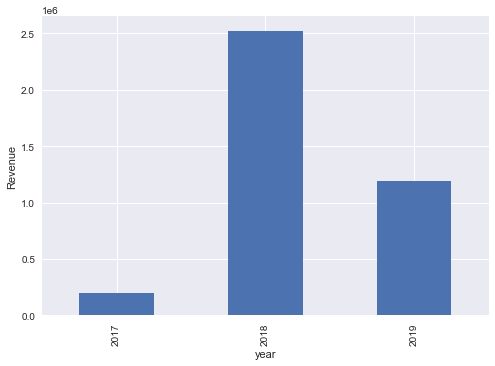

In [17]:
df.groupby(by=["year"]).sum()['price'].plot(kind='bar')
plt.ylabel("Revenue")
plt.savefig(IMAGE_DIR + "/total-revenue-by-year.png")

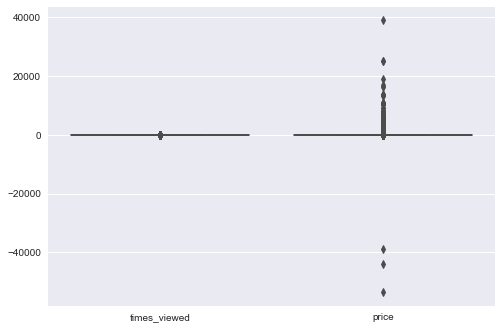

In [18]:
sns.boxplot(data=df[['times_viewed', 'price']])
plt.savefig(IMAGE_DIR + "/outliers-price-vs-times-viewed.png")

In [19]:
df.loc[df['price'] == 0].groupby("country").count()['invoice'].sort_values(ascending=False)

country
United Kingdom    5348
Germany              8
EIRE                 4
Australia            1
Belgium              1
Netherlands          1
Spain                1
Switzerland          1
Name: invoice, dtype: int64

In [20]:
df.loc[df['price'] < 0].groupby("country").count()['invoice'].sort_values(ascending=False)

country
United Kingdom    3
Name: invoice, dtype: int64

In [21]:
df = df[df['price'] >= 0]
print("Discard records where price is negative")

Discard records where price is negative


<AxesSubplot:xlabel='price', ylabel='Density'>

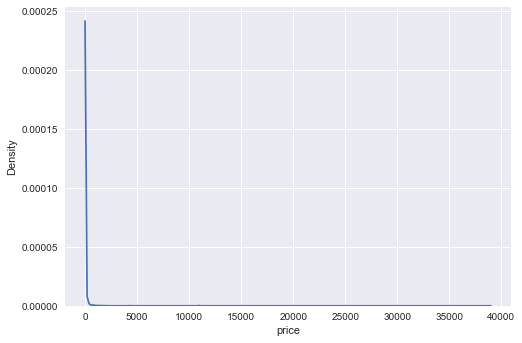

In [22]:
sns.kdeplot(x=df['price'])

<AxesSubplot:xlabel='price', ylabel='Density'>

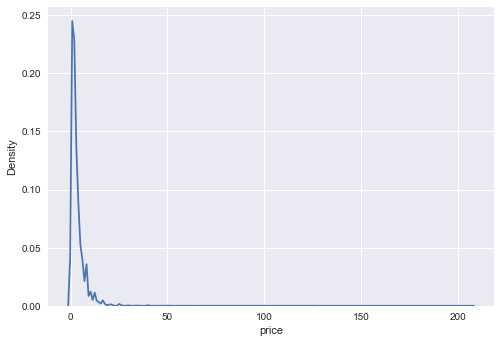

In [23]:
sns.kdeplot(x=df[df['zscore_price']<1.5]['price'])

In [24]:
n1 = df[df['price']>0].min()['price']
n2 = df[df['price']>n1].min()['price']
n3 = df[df['price']>n2].min()['price']
print("""
- Lowest value greater than 0: {}
- Lowest value greater than {}: {}
- Lowest value greater than {}: {}
""".format(n1, n1, n2, n2, n3))


- Lowest value greater than 0: 0.001
- Lowest value greater than 0.001: 0.01
- Lowest value greater than 0.01: 0.03



In [25]:
df['price_cut'] = pd.cut(df['price'], [0, 0.1, 1, 5, 10, 100, 1000])

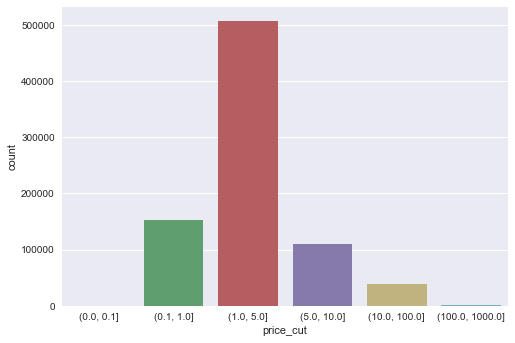

In [26]:
sns.countplot(x='price_cut', data=df)
plt.savefig(IMAGE_DIR + "/most-frequent-prices-distr.png")

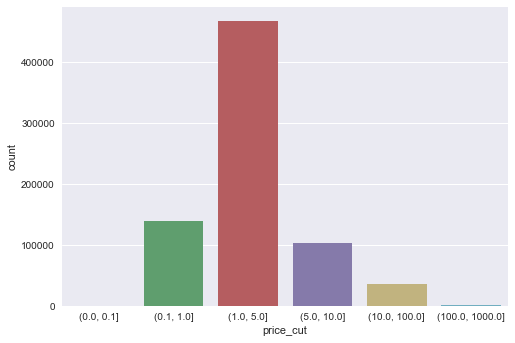

In [27]:
sns.countplot(x='price_cut', data=df.loc[df['country'] == "United Kingdom"])
plt.savefig(IMAGE_DIR + "/most-frequent-prices-distr-uk-only.png")

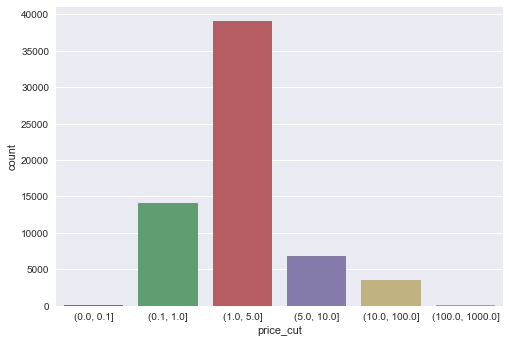

In [28]:
sns.countplot(x='price_cut', data=df.loc[df['country'] != "United Kingdom"])
plt.savefig(IMAGE_DIR + "/most-frequent-prices-distr-NOT-uk.png")

In [29]:
print("'Price' comes from the same distribution family in UK and in the rest of the countries (scaled by a factor of 10)")

'Price' comes from the same distribution family in UK and in the rest of the countries (scaled by a factor of 10)


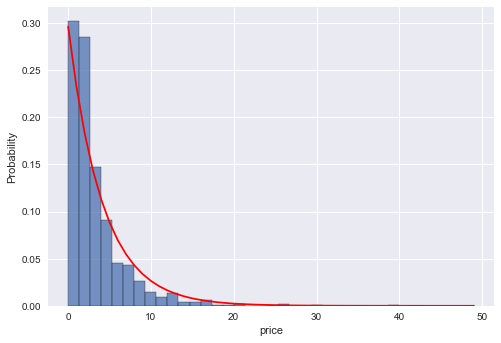

In [30]:
from scipy.stats import expon
price_relevant = df[df["price"]<40]["price"]
loc, scale = expon.fit(price_relevant)
sns.histplot(price_relevant, bins=30, stat="probability")
plt.plot(expon.pdf(np.linspace(0, 40), loc, scale), color="red")
plt.savefig(IMAGE_DIR + "/expon-approx-distr-price.png")

In [31]:
print("Most of the revenue comes from low priced subscriptions (less than 20 USD)")

Most of the revenue comes from low priced subscriptions (less than 20 USD)


Open questions to be addressed by the model in the next stage:
- If revenue depends more on low priced subscriptions, perhaps L2 penalty or MSE are *NOT* desirable due to the squared term. Is Lasso better than Ridge? Does MAE measure better the error than MSE?
- The price distribution seems to have a significant exponential contribution, which means that perhaps linear models are *NOT* desirable. Instead of a linear regression, could a cubic B-spline regression perform better? Are decision trees better than basis expansion regressions (all of them: linear, polynomial, penalized regressions, splines) ?
- The dataset represents a time-series. Is it possible that specific models aimed at time-series, such as ARIMA or LSTM Neural Networks outperform regressions?

In [32]:
df.to_pickle(DATA_DIR + "/preprocessed-dataset.pkl")
print("Saved preprocessed dataframe to " + DATA_DIR)

Saved preprocessed dataframe to ../capstone/data/input
